In [1]:
from functools import partial
from itertools import starmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iEEG_utils.loading import read_data
from iEEG_utils.processing import filtering, fooof_mod
# pymultitaper - https://github.com/fncokg/pymultitaper
from pymultitaper import multitaper_spectrogram

rng = np.random.default_rng()

C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:14: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


In [2]:
# use file selection dialog to choose folder with data storage
fstr = read_data.select_directory()
print(fstr)

C:\Users\jmile3\OneDrive - SCH\sEEG_data\Thalamic\c66248


In [3]:
# IF following JTM's data processing workflow
#### i.e.: 
#### iEEG.csv of timeseries for regions of interest
#### montage.csv of research montage info
#### channels.csv with metadata (loosely following iEEG-BIDS)
# the next line will load the iEEG.csv file and metadata
# can set load_meta = False to just load the timeseries data
# will need sampling rate, though (typically in "channels.csv")

montage = read_data.load_info(fstr,ftype="montage")
montage.name = montage.name.replace(" ","",regex=True)
srate,data = read_data.load_iEEG(fstr,load_meta=True)
# newcols = list(map(lambda x: x.replace(" ",""),data.columns))
data.rename(mapper=dict(zip(data.columns,list(map(lambda x: x.replace(" ",""),data.columns)))),axis='columns',inplace=True)
origtime = pd.to_datetime(data.time,format='%H:%M:%S.%f')
origts = np.array(origtime-origtime[0])/ np.timedelta64(1, 's')

print(srate)
print(data.shape)

display(data.head())

2000
(600000, 17)


,time,LAA3,LAA4,LAA5,LAA6,LAA14,LAA15,LAA16,RAA2,RAA3,RAA4,RAA5,RAA6,RAA15,RAA16,DC1,DC2
0,14:45:50.325702,-19.611425,-16.258617,-22.628952,-19.343200,154.332237,76.412987,41.007338,-11.162350,-13.106978,-10.558844,-35.771958,-25.378254,57.167871,14.922494,-36.643688,-38.118923
1,14:45:50.326202,-21.824278,-16.996235,-21.153716,-16.459786,152.052327,74.937751,38.794485,-7.541317,-10.156507,-9.083609,-34.296722,-23.165401,58.576050,18.610583,-49.049076,-49.719638
2,14:45:50.326702,-18.136189,-16.258617,-16.728010,-17.130347,153.393450,74.870695,38.727428,-12.637585,-10.156507,-6.870756,-34.296722,-24.573580,57.838432,17.135347,-86.198185,-86.935803
3,14:45:50.327202,-13.039922,-8.949496,-14.582213,-16.392729,154.734574,74.870695,37.989811,-19.879649,-18.203246,-12.704641,-37.180137,-30.407465,51.199873,10.496788,-116.038173,-116.775791
4,14:45:50.327702,-2.042713,-2.377993,-10.156507,-8.413047,155.405135,74.803639,37.252193,-17.733853,-17.465628,-15.655112,-37.180137,-28.194612,49.724638,10.496788,-225.473815,-226.144377


In [4]:
montage

,ID,age,ch,name,region
0,c66248,9.08,121,RAA2,Thalmus proper
1,c66248,9.08,122,RAA3,Thalamus proper
2,c66248,9.08,123,RAA4,Thalamus proper
3,c66248,9.08,124,RAA5,Thalamus proper
4,c66248,9.08,125,RAA6,Thalamus proper
5,c66248,9.08,134,RAA15,r_superiorfrontal
6,c66248,9.08,135,RAA16,r_superiorfrontal
7,c66248,9.08,48,LAA3,Thalamus proper
8,c66248,9.08,49,LAA4,Thalamus proper
9,c66248,9.08,50,LAA5,Thalamus proper


In [5]:
# rate to resample to (best if power of 2)
resrate = 1024
# upper bound of frequency range (must be < resrate/2)
lpfreq = 150
ch1 = "LAA14"
ch2 = "LAA15"
ts,reref = filtering.bipolar_reref(data.loc[:,[ch1,ch2]], srate, resrate, lpfreq=lpfreq)


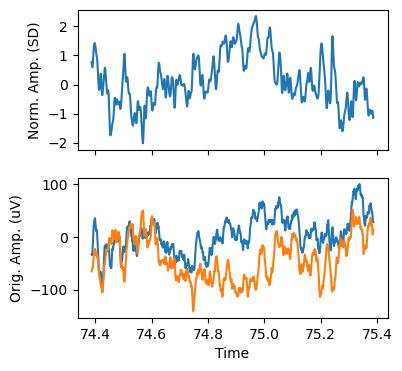

In [6]:
t1 = rng.integers(resrate, high=len(reref))
t0 = t1-resrate
tfilt = (origts>=ts[t0]) & (origts<=ts[t1])
fig, ax = plt.subplots(2,1,sharex=True,figsize=[4,4])
ax[0].plot(ts[t0:t1],reref[t0:t1])
ax[1].plot(origts[tfilt], filtering.bfilt(np.array([data.loc[tfilt,ch2],data.loc[tfilt,ch1]]).T,srate,4,[59,61],"stop"))
ax[0].set_xlabel("")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Norm. Amp. (SD)")
ax[1].set_ylabel("Orig. Amp. (uV)")
plt.show()

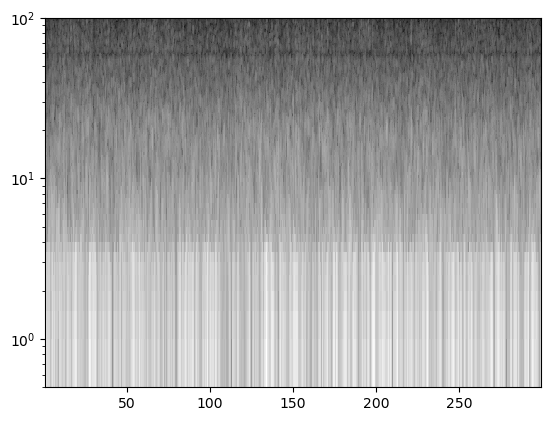

In [7]:
# process data from each subj
# set some parameters that will be used for processing
#####
t_res = 1/4 # time between spectra calculations (seconds)
f_res = 1/2 # frequency bin size for spectra (Hz)
t_win = 1 # in seconds
fmin = 0.5 # minimum frequency to save
fmax = 100 # max frequency to save (should be below 256)
####

f,sts,spectra = multitaper_spectrogram(reref,resrate,time_step=t_res,window_length=t_win,NW=3,
                                       detrend='off',freq_range=[fmin, fmax],nfft=2*t_win*resrate,
                                       db_scale=False,boundary_pad=False)

fig, ax = plt.subplots()
ax.pcolormesh(sts,f,np.log10(spectra[1:,1:]),cmap="grey", shading="flat")
ax.set_ylim([fmin,fmax])
ax.set_yscale("log")
plt.show()

In [8]:
# fit 1/f with Lorentzian
spect_fits = fooof_mod.fit_group(f,spectra.T)


Running FOOOFGroup across 1197 power spectra.


In [9]:
model_spect = fooof_mod.model_spect
intfs = np.concatenate((np.linspace(0.5,1,sum(f>50)+1),np.linspace(1.05,10,sum(f>10)),f[f>10]))
rowixs = [[ix] for ix in range(max(spectra.shape))]
partial_func = partial(model_spect,model_obj=spect_fits,freqs=f,intfs=intfs,save_fit=True)
calc_resids = starmap(partial_func,rowixs)
resid_spects = np.array(list(calc_resids))

C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:98: OptimizeWarning: Covariance of the parameters could not be estimated
  reparams,_ = curve_fit(lorentzian_function, intfs, np.log10(intfx(intfs)), p0=[offset,knee,exp], maxfev=2500)
C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:98: OptimizeWarning: Covariance of the parameters could not be estimated
  reparams,_ = curve_fit(lorentzian_function, intfs, np.log10(intfx(intfs)), p0=[offset,knee,exp], maxfev=2500)
C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:98: OptimizeWarning: Covariance of the parameters could not be estimated
  reparams,_ = curve_fit(lorentzian_function, intfs, np.log10(intfx(intfs)), p0=[offset,knee,exp], maxfev=2500)
C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:9

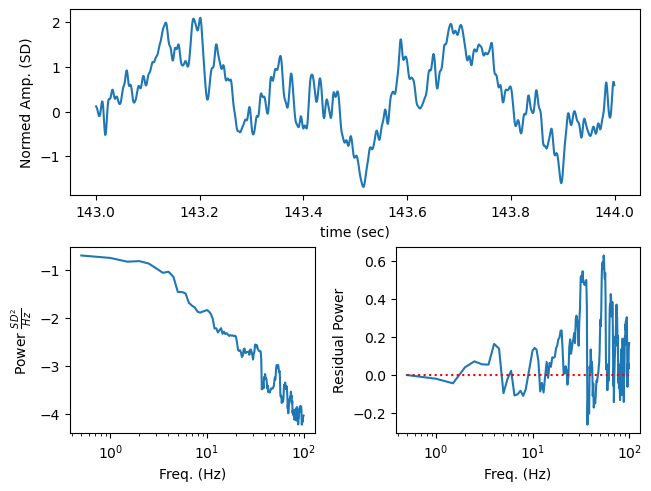

In [14]:
randix = rng.integers(0, high=max(resid_spects.shape))
randt = sts[randix]
plot_ixs = (ts>=randt-(t_win/2))&(ts<=randt+(t_win/2))

fig = plt.figure(layout="constrained")

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(ts[plot_ixs],reref[plot_ixs])
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("Normed Amp. (SD)")

ax2.plot(f,np.log10(spectra[:,randix]))
ax2.set_xscale("log")
ax2.set_xlabel("Freq. (Hz)")
ax2.set_ylabel("Power "+ r'$\frac{SD^2}{Hz}$')

ax3.plot(f,resid_spects.T[:,randix])
ax3.plot([f[0],f[-1]],[0,0],"r:")
ax3.set_xlabel("Freq. (Hz)")
ax3.set_ylabel("Residual Power")
ax3.set_xscale("log")